In [2]:
import os
import sys
import copy
import codecs
from glob import glob
from datetime import datetime
import random

In [4]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 12

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
#DATA = "../input/sleep-state"
PP_DATA = r"D:\2nd_semester\data_mining\Project\Data_demo"
WINDOW_SIZE = 100
bs = 64

In [16]:
#!pip install git+https://www.github.com/keras-team/keras-contrib.git

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm, tqdm_notebook
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, MaxPool1D, Activation
from tensorflow.keras.layers import Reshape, LSTM, TimeDistributed, Bidirectional, BatchNormalization, Flatten, RepeatVector
#from tensorflow.keras.layers import CuDNNGRU, CuDNNLSTM
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_auc_score, roc_curve

import mne
from mne.io import read_raw_edf

In [7]:
fnames = sorted(glob(os.path.join(PP_DATA, "*.npz")))
len(fnames)
fnames[0]

'D:\\2nd_semester\\data_mining\\Project\\Data_demo\\SC4001E0.txt.npz'

In [8]:
#Data generator
total_fs = [f for f in fnames if f.split("/")[-1][:5]]
print(len(total_fs), total_fs[0])
total_data = {k: np.load(k) for k in total_fs}

1 D:\2nd_semester\data_mining\Project\Data_demo\SC4001E0.txt.npz


In [11]:
samples = total_data[r"D:\2nd_semester\data_mining\Project\Data_demo\SC4001E0.txt.npz"]
samples['x'].shape  # (n_epochs, sample_len, n_channels)

(841, 3000, 1)

In [20]:
samples = total_data["C:/Users/pratik/Desktop/DM Project/New folder/np\SC4001E0.npz"]
samples['x'].shape  # (n_epochs, sample_len, n_channels)

(841, 3000, 1)

In [12]:
X = np.zeros((0, 3000, 1))
y = []
for fn in total_fs:
    samples = np.load(fn)
    X_data = samples["x"]
    X = np.concatenate((X, X_data), axis=0)
    y.extend(samples["y"])
y = np.array(y)

In [83]:
Y = samples['y']

In [66]:
print(X.shape)
print(y.shape)

(841, 3000)
(3,)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=42
)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.1,
    random_state=42
)

In [16]:
X_train.shape, X_test.shape, X_val.shape

((680, 3000, 1), (85, 3000, 1), (76, 3000, 1))

In [17]:
def rescale_array(X):
    X = X / 20
    X = np.clip(X, -5, 5)
    return X

def aug_X(X):
    scale = 1 + np.random.uniform(-0.1, 0.1)
    offset = np.random.uniform(-0.1, 0.1)
    noise = np.random.normal(scale=0.05, size=X.shape)
    X = scale * X + offset + noise
    return X

def gen(dict_files, scale=True, aug=False):
    while True:
        record_name = random.choice(list(dict_files.keys()))
        batch_data = dict_files[record_name]
        all_rows = batch_data['x']

        for i in range(10):
            start_index = random.choice(range(all_rows.shape[0]-WINDOW_SIZE))

            X = all_rows[start_index:start_index+WINDOW_SIZE, ...]
            Y = batch_data['y'][start_index:start_index+WINDOW_SIZE]

            X = np.expand_dims(X, 0)
            Y = np.expand_dims(Y, -1)
            Y = np.expand_dims(Y, 0)

            if aug:
                X = aug_X(X)
                
            if scale:
                X = rescale_array(X)

            yield np.squeeze(X, axis=0), np.squeeze(Y, axis=0)

In [18]:
def data_generator(X_samples, y_samples, bs=32, label=True):
    i = 0
#     X_samples = X_samples[:]
#     y_samples = y_samples[:]
    while True:
        X_temp = X_samples[i:i + bs]
        y_temp = y_samples[i:i + bs]
        
        X_temp = np.array([rescale_array(sample) for sample in X_temp])
        y_temp = np.array(y_temp)
        if label:
            yield X_temp, y_temp
        else:
            yield X_temp

        i += bs

In [19]:
#model
Fs = 100

def model_baseline_2017(n_classes=5, use_sub_layer=False, summary=True):
    # two conv-nets in parallel for feature learning, 
    # one with fine resolution another with coarse resolution    
    # network to learn fine features
    inputLayer = Input(shape=(3000, 1), name='inLayer')
    convFine = Conv1D(filters=64, kernel_size=int(Fs/2), strides=int(Fs/16), padding='same', activation='relu', name='fConv1')(inputLayer)
    convFine = MaxPool1D(pool_size=8, strides=8, name='fMaxP1')(convFine)
    convFine = Dropout(rate=0.5, name='fDrop1')(convFine)
    convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv2')(convFine)
    convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv3')(convFine)
    convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv4')(convFine)
    convFine = MaxPool1D(pool_size=4, strides=4, name='fMaxP2')(convFine)
    fineShape = convFine.get_shape()
    convFine = Flatten(name='fFlat1')(convFine)
    
    # network to learn coarse features
    convCoarse = Conv1D(filters=32, kernel_size=Fs*4, strides=int(Fs/2), padding='same', activation='relu', name='cConv1')(inputLayer)
    convCoarse = MaxPool1D(pool_size=4, strides=4, name='cMaxP1')(convCoarse)
    convCoarse = Dropout(rate=0.5, name='cDrop1')(convCoarse)
    convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv2')(convCoarse)
    convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv3')(convCoarse)
    convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv4')(convCoarse)
    convCoarse = MaxPool1D(pool_size=2, strides=2, name='cMaxP2')(convCoarse)
    coarseShape = convCoarse.get_shape()
    convCoarse = Flatten(name='cFlat1')(convCoarse)
    
    # concatenate coarse and fine cnns
    mergeLayer = concatenate([convFine, convCoarse], name='merge_1')
    outLayer = Dropout(rate=0.5, name='mDrop1')(mergeLayer)
    if use_sub_layer:
        sub_layer = Dense(1024, activation="relu", name='sub_layer')(outLayer)
    # model = Model(inputLayer, mergeLayer)
    
    # LSTM
    outLayer = Reshape((1, int(fineShape[1]*fineShape[2] + coarseShape[1]*coarseShape[2])), name='reshape1')(outLayer)
    outLayer = Bidirectional(LSTM(128, activation='relu', dropout=0.5, name='bLstm1'))(outLayer)
    outLayer = Reshape((1, int(outLayer.get_shape()[1])))(outLayer)
    outLayer = Bidirectional(LSTM(128, activation='relu', dropout=0.5, name='bLstm2'))(outLayer)
    
    # merge out_layer and sub_layer
    if use_sub_layer:
        outLayer = concatenate([outLayer, sub_layer], name='merge_2')
        outLayer = Dropout(rate=0.5, name='mDrop2')(outLayer)
        outLayer = Dense(256, activation="relu", name='sub_layer_2')(outLayer)
    outLayer = Dropout(rate=0.5, name='merge_out_sub')(outLayer)
    
    # Classify
    outLayer = Dense(n_classes, activation='softmax', name='outLayer')(outLayer)
    model = Model(inputLayer, outLayer)
    optimizer = keras.optimizers.Adam(lr=1e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
    
    if summary:
        model.summary()

    return model

model_2017 = model_baseline_2017(use_sub_layer=False, summary=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inLayer (InputLayer)            [(None, 3000, 1)]    0                                            
__________________________________________________________________________________________________
fConv1 (Conv1D)                 (None, 500, 64)      3264        inLayer[0][0]                    
__________________________________________________________________________________________________
cConv1 (Conv1D)                 (None, 60, 32)       12832       inLayer[0][0]                    
__________________________________________________________________________________________________
fMaxP1 (MaxPooling1D)           (None, 62, 64)       0           fConv1[0][0]                     
______________________________________________________________________________________________

In [20]:
fs = 100

def model_baseline_2019(n_classes=5, use_sub_layer=False, use_rnn=True):
    """Recurrent_Deep_Neural_Networks_for_Real-Time_Sleep
    """
    inputLayer = Input(shape=(3000, 1), name='inLayer')
    convFine = Conv1D(filters=64, kernel_size=int(Fs/2), strides=int(Fs/16), padding='same', activation='relu', name='fConv1')(inputLayer)
    convFine = MaxPool1D(pool_size=8, strides=8, name='fMaxP1')(convFine)
    convFine = Dropout(rate=0.5, name='fDrop1')(convFine)
    convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv2')(convFine)
    convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv3')(convFine)
    convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv4')(convFine)
    convFine = MaxPool1D(pool_size=4, strides=4, name='fMaxP2')(convFine)
    fineShape = convFine.get_shape()
    convFine = Flatten(name='fFlat1')(convFine)
    
    # network to learn coarse features
    convCoarse = Conv1D(filters=32, kernel_size=Fs*4, strides=int(Fs/2), padding='same', activation='relu', name='cConv1')(inputLayer)
    convCoarse = MaxPool1D(pool_size=4, strides=4, name='cMaxP1')(convCoarse)
    convCoarse = Dropout(rate=0.5, name='cDrop1')(convCoarse)
    convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv2')(convCoarse)
    convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv3')(convCoarse)
    convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv4')(convCoarse)
    convCoarse = MaxPool1D(pool_size=2, strides=2, name='cMaxP2')(convCoarse)
    coarseShape = convCoarse.get_shape()
    convCoarse = Flatten(name='cFlat1')(convCoarse)
    
    # concatenate coarse and fine cnns
    mergeLayer = concatenate([convFine, convCoarse], name='merge_1')
    outLayer = Dropout(rate=0.5, name='mDrop1')(mergeLayer)
    
    outLayer = Reshape((1, outLayer.get_shape()[1]), name='reshape1')(outLayer)
    outLayer = LSTM(64, return_sequences=True)(outLayer)
    outLayer = LSTM(64, return_sequences=False)(outLayer)

    # Classify
    outLayer = Dense(n_classes, activation='softmax', name='outLayer')(outLayer)
    model = Model(inputLayer, outLayer)
    optimizer = keras.optimizers.Adam(lr=1e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
    model.summary()
    return model

model_2019 = model_baseline_2019(use_sub_layer=False, use_rnn=False)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inLayer (InputLayer)            [(None, 3000, 1)]    0                                            
__________________________________________________________________________________________________
fConv1 (Conv1D)                 (None, 500, 64)      3264        inLayer[0][0]                    
__________________________________________________________________________________________________
cConv1 (Conv1D)                 (None, 60, 32)       12832       inLayer[0][0]                    
__________________________________________________________________________________________________
fMaxP1 (MaxPooling1D)           (None, 62, 64)       0           fConv1[0][0]                     
____________________________________________________________________________________________

In [22]:
def evaluate_metrics(cm,classes):

    print ("Confusion matrix:")
    print (cm)

    cm = cm.astype(np.float32)
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    # https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP / (TP + FN)
    # Specificity or true negative rate
    TNR = TN / (TN + FP)
    # Precision or positive predictive value
    PPV = TP / (TP + FP)
    # Negative predictive value
    NPV = TN / (TN + FN)
    # Fall out or false positive rate
    FPR = FP / (FP + TN)
    # False negative rate
    FNR = FN / (TP + FN)
    # False discovery rate
    FDR = FP / (TP + FP)

    # Overall accuracy
    ACC = (TP + TN) / (TP + FP + FN + TN)
    # ACC_micro = (sum(TP) + sum(TN)) / (sum(TP) + sum(FP) + sum(FN) + sum(TN))
    ACC_macro = np.mean(ACC) # to get a sense of effectiveness of our method on the small classes we computed this average (macro-average)

    F1 = (2 * PPV * TPR) / (PPV + TPR)
    F1_macro = np.mean(F1)

    print ("Sample: {}".format(int(np.sum(cm))))
    n_classes = len(classes)
    for index_ in range(n_classes):
        print ("{}: {}".format(classes[index_], int(TP[index_] + FN[index_])))


    return ACC_macro,ACC, F1_macro, F1, TPR, TNR, PPV

In [23]:
#train
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highpass, fs, order=4):
    nyq = 0.5 * fs
    #       low = lowcut / nyq
    high = highpass / nyq
    b, a = butter(order, high, btype='highpass')
    return b, a
   
def butter_bandpass_filter(data, highpass, fs, order=4):
    b, a = butter_bandpass(0, highpass, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [24]:
sample = X_train[0]

In [25]:
max(sample), min(sample)

(array([102.44688416]), array([-112.66812897]))

In [26]:
res = butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4)

In [27]:
max(res), min(res)

(array([0.49423895]), array([-0.54354974]))

In [28]:
checkpoint = ModelCheckpoint("model_cps", monitor='val_loss', verbose=1, save_best_only=True, mode='max')
# early = EarlyStopping(monitor="val_loss", mode="max", patience=20, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_loss", mode="max", patience=5, verbose=2)
csv_logger = CSVLogger('log_training.csv', append=True, separator=',')
callbacks_list = [
    checkpoint,
#     early,
    redonplat,
    csv_logger,
]

In [168]:
y_train_ = to_categorical(y_train)
y_val_ = to_categorical(y_val)
y_test_ = to_categorical(y_test)

In [206]:
import seq2seq

ModuleNotFoundError: No module named 'seq2seq'

In [30]:
hist = model_2017.fit(
    X_train, y_train_, batch_size=64, epochs=30, validation_data=(X_val, y_val_), callbacks=callbacks_list
)

Train on 680 samples, validate on 76 samples
Epoch 1/30
640/680 [===========================>..] - ETA: 0s - loss: 2.0639 - acc: 0.1937
Epoch 00001: val_loss improved from -inf to 1.54399, saving model to model_cps
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


ValueError: Attempted to save a function b'__inference_forward_bLstm1_layer_call_fn_24446' which references a symbolic Tensor Tensor("dropout/mul_1:0", shape=(None, 2816), dtype=float32) that is not a simple constant. This is not supported.

In [31]:
y_pred = model_2017.predict(X_test, batch_size=bs)
y_pred = np.array([np.argmax(s) for s in y_pred])
f1 = f1_score(y_test, y_pred, average="macro")
print(">>> f1 score: {}".format(f1))
report = classification_report(y_test, y_pred)
print(report)

>>> f1 score: 0.24005352363960747
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.00      0.00      0.00         4
           2       0.54      0.83      0.66        30
           3       0.42      0.76      0.54        21
           4       0.00      0.00      0.00        14

    accuracy                           0.48        85
   macro avg       0.19      0.32      0.24        85
weighted avg       0.30      0.48      0.37        85



In [32]:
model_2017.save_weights("raw_model_2017.h5")

In [33]:
accuracy_score(y_test, y_pred)

0.4823529411764706

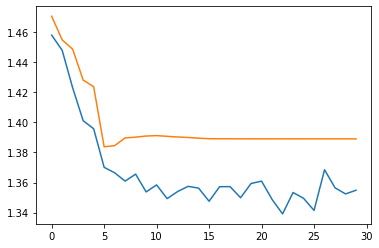

In [53]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])

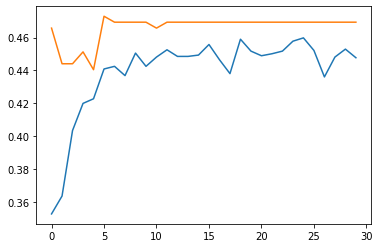

In [54]:
plt.plot(hist.history["acc"])
plt.plot(hist.history["val_acc"])

In [172]:
pp_X_train = np.array([butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_train])
pp_X_val = np.array([butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_val])
pp_X_test = np.array([butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_test])

In [174]:
pp_X_test = pp_X_test.reshape(76,3000,1)

In [176]:
pp_X_train = pp_X_train.reshape(765,3000,1)

In [190]:
model_2019 = model_baseline_2019()
hist_19 = model_2019.fit(
    pp_X_train, y_train_, batch_size=64, epochs=120, validation_data=(pp_X_val, y_val_), callbacks=callbacks_list
)

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inLayer (InputLayer)            [(None, 3000, 1)]    0                                            
__________________________________________________________________________________________________
fConv1 (Conv1D)                 (None, 500, 64)      3264        inLayer[0][0]                    
__________________________________________________________________________________________________
cConv1 (Conv1D)                 (None, 60, 32)       12832       inLayer[0][0]                    
__________________________________________________________________________________________________
fMaxP1 (MaxPooling1D)           (None, 62, 64)       0           fConv1[0][0]                     
____________________________________________________________________________________________

Epoch 12/120
704/765 [==========================>...] - ETA: 0s - loss: 1.4504 - acc: 0.2244
Epoch 00012: val_loss did not improve from 1.60878
765/765 [==============================] - 1s 2ms/sample - loss: 1.4493 - acc: 0.2248 - val_loss: 1.6029 - val_acc: 0.1842
Epoch 13/120
704/765 [==========================>...] - ETA: 0s - loss: 1.4467 - acc: 0.2273
Epoch 00013: val_loss did not improve from 1.60878
765/765 [==============================] - 1s 2ms/sample - loss: 1.4472 - acc: 0.2248 - val_loss: 1.6029 - val_acc: 0.1842
Epoch 14/120
704/765 [==========================>...] - ETA: 0s - loss: 1.4488 - acc: 0.2230
Epoch 00014: val_loss did not improve from 1.60878
765/765 [==============================] - 1s 2ms/sample - loss: 1.4472 - acc: 0.2248 - val_loss: 1.6029 - val_acc: 0.1842
Epoch 15/120
704/765 [==========================>...] - ETA: 0s - loss: 1.4524 - acc: 0.2230
Epoch 00015: val_loss did not improve from 1.60878
765/765 [==============================] - 2s 2ms/sampl

Epoch 70/120
704/765 [==========================>...] - ETA: 0s - loss: 1.4402 - acc: 0.2301
Epoch 00070: val_loss did not improve from 1.60878
765/765 [==============================] - 1s 2ms/sample - loss: 1.4477 - acc: 0.2248 - val_loss: 1.6029 - val_acc: 0.1842
Epoch 71/120
704/765 [==========================>...] - ETA: 0s - loss: 1.4424 - acc: 0.2259
Epoch 00071: val_loss did not improve from 1.60878

Epoch 00071: ReduceLROnPlateau reducing learning rate to 9.999999010570977e-19.
765/765 [==============================] - 1s 2ms/sample - loss: 1.4464 - acc: 0.2248 - val_loss: 1.6029 - val_acc: 0.1842
Epoch 72/120
704/765 [==========================>...] - ETA: 0s - loss: 1.4418 - acc: 0.2315
Epoch 00072: val_loss did not improve from 1.60878
765/765 [==============================] - 1s 2ms/sample - loss: 1.4462 - acc: 0.2248 - val_loss: 1.6029 - val_acc: 0.1842
Epoch 73/120
704/765 [==========================>...] - ETA: 0s - loss: 1.4463 - acc: 0.2244
Epoch 00073: val_loss did

Epoch 99/120
704/765 [==========================>...] - ETA: 0s - loss: 1.4522 - acc: 0.2202
Epoch 00099: val_loss did not improve from 1.60878
765/765 [==============================] - 1s 2ms/sample - loss: 1.4481 - acc: 0.2248 - val_loss: 1.6029 - val_acc: 0.1842
Epoch 100/120
704/765 [==========================>...] - ETA: 0s - loss: 1.4477 - acc: 0.2273
Epoch 00100: val_loss did not improve from 1.60878
765/765 [==============================] - 1s 2ms/sample - loss: 1.4459 - acc: 0.2261 - val_loss: 1.6029 - val_acc: 0.1842
Epoch 101/120
704/765 [==========================>...] - ETA: 0s - loss: 1.4490 - acc: 0.2230
Epoch 00101: val_loss did not improve from 1.60878

Epoch 00101: ReduceLROnPlateau reducing learning rate to 9.999999998199588e-25.
765/765 [==============================] - 1s 2ms/sample - loss: 1.4468 - acc: 0.2248 - val_loss: 1.6029 - val_acc: 0.1842
Epoch 102/120
704/765 [==========================>...] - ETA: 0s - loss: 1.4446 - acc: 0.2287
Epoch 00102: val_loss 

In [188]:
y_pred = model_2019.predict(pp_X_test, batch_size=bs)
y_pred = np.array([np.argmax(s) for s in y_pred])
f1 = f1_score(y_test, y_pred, average="macro")
print(">>> f1 score: {}".format(f1))
report = classification_report(y_test, y_pred)
print(report)

>>> f1 score: 0.25336105336105336
              precision    recall  f1-score   support

           0       0.62      0.81      0.70        16
           1       0.00      0.00      0.00         5
           2       0.40      0.96      0.56        23
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        12

    accuracy                           0.46        76
   macro avg       0.20      0.35      0.25        76
weighted avg       0.25      0.46      0.32        76



In [189]:
print(accuracy_score(y_test, y_pred))

0.4605263157894737


In [180]:
model_2017 = model_baseline_2017()
hist2 = model_2017.fit(
    pp_X_train, y_train_, batch_size=64, epochs=30, validation_data=(pp_X_val, y_val_), callbacks=callbacks_list
)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inLayer (InputLayer)            [(None, 3000, 1)]    0                                            
__________________________________________________________________________________________________
fConv1 (Conv1D)                 (None, 500, 64)      3264        inLayer[0][0]                    
__________________________________________________________________________________________________
cConv1 (Conv1D)                 (None, 60, 32)       12832       inLayer[0][0]                    
__________________________________________________________________________________________________
fMaxP1 (MaxPooling1D)           (None, 62, 64)       0           fConv1[0][0]                     
____________________________________________________________________________________________

ValueError: Attempted to save a function b'__inference_forward_bLstm1_layer_call_fn_85211' which references a symbolic Tensor Tensor("dropout/mul_1:0", shape=(None, 2816), dtype=float32) that is not a simple constant. This is not supported.

In [181]:
y_pred = model_2017.predict(pp_X_test, batch_size=bs)
y_pred = np.array([np.argmax(s) for s in y_pred])
f1 = f1_score(y_test, y_pred, average="macro")
print(">>> f1 score: {}".format(f1))
report = classification_report(y_test, y_pred)
print(report)

>>> f1 score: 0.06956521739130435
              precision    recall  f1-score   support

           0       0.21      1.00      0.35        16
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00        23
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        12

    accuracy                           0.21        76
   macro avg       0.04      0.20      0.07        76
weighted avg       0.04      0.21      0.07        76



In [182]:
accuracy_score(y_test, y_pred)

0.21052631578947367

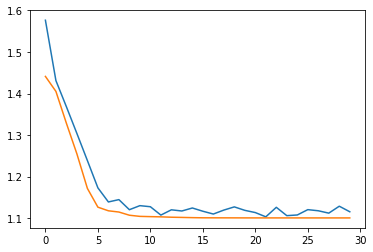

In [62]:
plt.plot(hist2.history["loss"])
plt.plot(hist2.history["val_loss"])

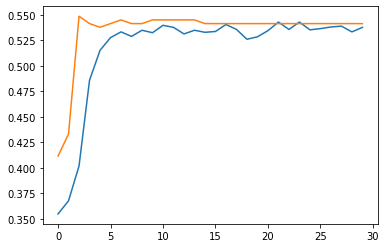

In [63]:
plt.plot(hist2.history["acc"])
plt.plot(hist2.history["val_acc"])

In [64]:
# bs = 128
# epochs = 5
# hists = []

# for i in range(epochs):
#     print(">>> Epochs {}".format(i + 1))
#     hist = model_2017.fit_generator(
#         data_generator(X_train, y_train_, bs=bs),
#         validation_data=data_generator(X_val, y_val_, bs=bs),
#         epochs=1,
#         steps_per_epoch=len(X_train) // bs,
#         validation_steps=len(X_val) // bs,
#         callbacks=callbacks_list
#     )
#     y_pred = model_2017.predict(X_test, batch_size=bs)
#     y_pred = np.array([np.argmax(s) for s in y_pred])
# #     f1 = f1_score(y_test, y_pred, average="macro")
# #     print(">>> f1 score: {}".format(f1))
#     report = classification_report(y_test, y_pred)
#     print(report)
#     hists.append(hist.history)

In [41]:
model_2017.save_weights("pp_model_2017.h5")

In [42]:
model_json = model_2017.to_json()
with open("eeg_model_2017_config.json", "w") as f:
    f.write(model_json)

In [43]:
!ls log_training.csv

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [45]:
import pandas as pd
file = pd.read_json('eeg_model_2017_config.json')
file

,class_name,config,keras_version,backend
input_layers,Model,"[[inLayer, 0, 0]]",2.2.4-tf,tensorflow
layers,Model,"[{'class_name': 'InputLayer', 'config': {'batc...",2.2.4-tf,tensorflow
name,Model,model_2,2.2.4-tf,tensorflow
output_layers,Model,"[[outLayer, 0, 0]]",2.2.4-tf,tensorflow


# Machine Learning

In [85]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.09,random_state= 10)

In [144]:
knn = KNeighborsClassifier(n_neighbors = 1)

In [145]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [154]:
X_train.shape

(765, 3000)

In [146]:
prediction = knn.predict(X_test)
print('With KNN (K=3) accuracy is: ',knn.score(X_test,y_test))

With KNN (K=3) accuracy is:  0.15789473684210525


In [155]:
pp_X_train = pp_X_train.reshape(680,3000)

In [156]:
knn.fit(pp_X_train, y_train_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [160]:
pp_X_test = pp_X_test.reshape(85,3000)

In [161]:
pp_X_test.shape

(85, 3000)

In [162]:
prediction = knn.predict(pp_X_test)
print('With KNN (K=3) accuracy is: ',knn.score(pp_X_test,y_test_))

With KNN (K=3) accuracy is:  0.07058823529411765


In [191]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

In [203]:
nb = GaussianNB()
nb.fit(X_train,y_train)
prediction = nb.predict(X_test)

print('With NB accuracy is: ',nb.score(X_test,y_test)) # accuracy

With NB accuracy is:  0.5394736842105263


In [204]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
prediction = dtree.predict(X_test)

print('With decision tree accuracy is: ',dtree.score(X_test,y_test)) # accuracy

With decision tree accuracy is:  0.27631578947368424


In [205]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train,y_train)
prediction = rf.predict(X_test)

print('With Random forest accuracy is: ',rf.score(X_test,y_test)) # accuracy

With Random forest accuracy is:  0.5789473684210527


In [201]:
from sklearn.svm import SVC

In [202]:

svc = SVC(kernel='linear', C=1,gamma='auto')
svc.fit(X, Y)
svc.fit(X_train,y_train)
 
prediction = svc.predict(X_test)

print('With SVM accuracy is: ',svc.score(X_test,y_test)) # accuracy

With SVM accuracy is:  0.2236842105263158
